# Additional Visualizations

Section: e. Analyze the educational background of customers who lodged complaints in the last two years.

**Part of:** [marketing_campaign_082825_working.ipynb](./marketing_campaign_082825_working.ipynb)

In [1]:
# Setup and data loading
from utils import (
    ProjectConfig,
    load_intermediate_results,
    save_project_figure,
    reset_plot_settings,
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

config = ProjectConfig()
# Load data from previous notebook
df = load_intermediate_results("data_from_08_step_6.pkl", config)

## e. Analyze the educational background of customers who lodged complaints in the last two years.

Saved: figures\Education_Background_People_Complain.png


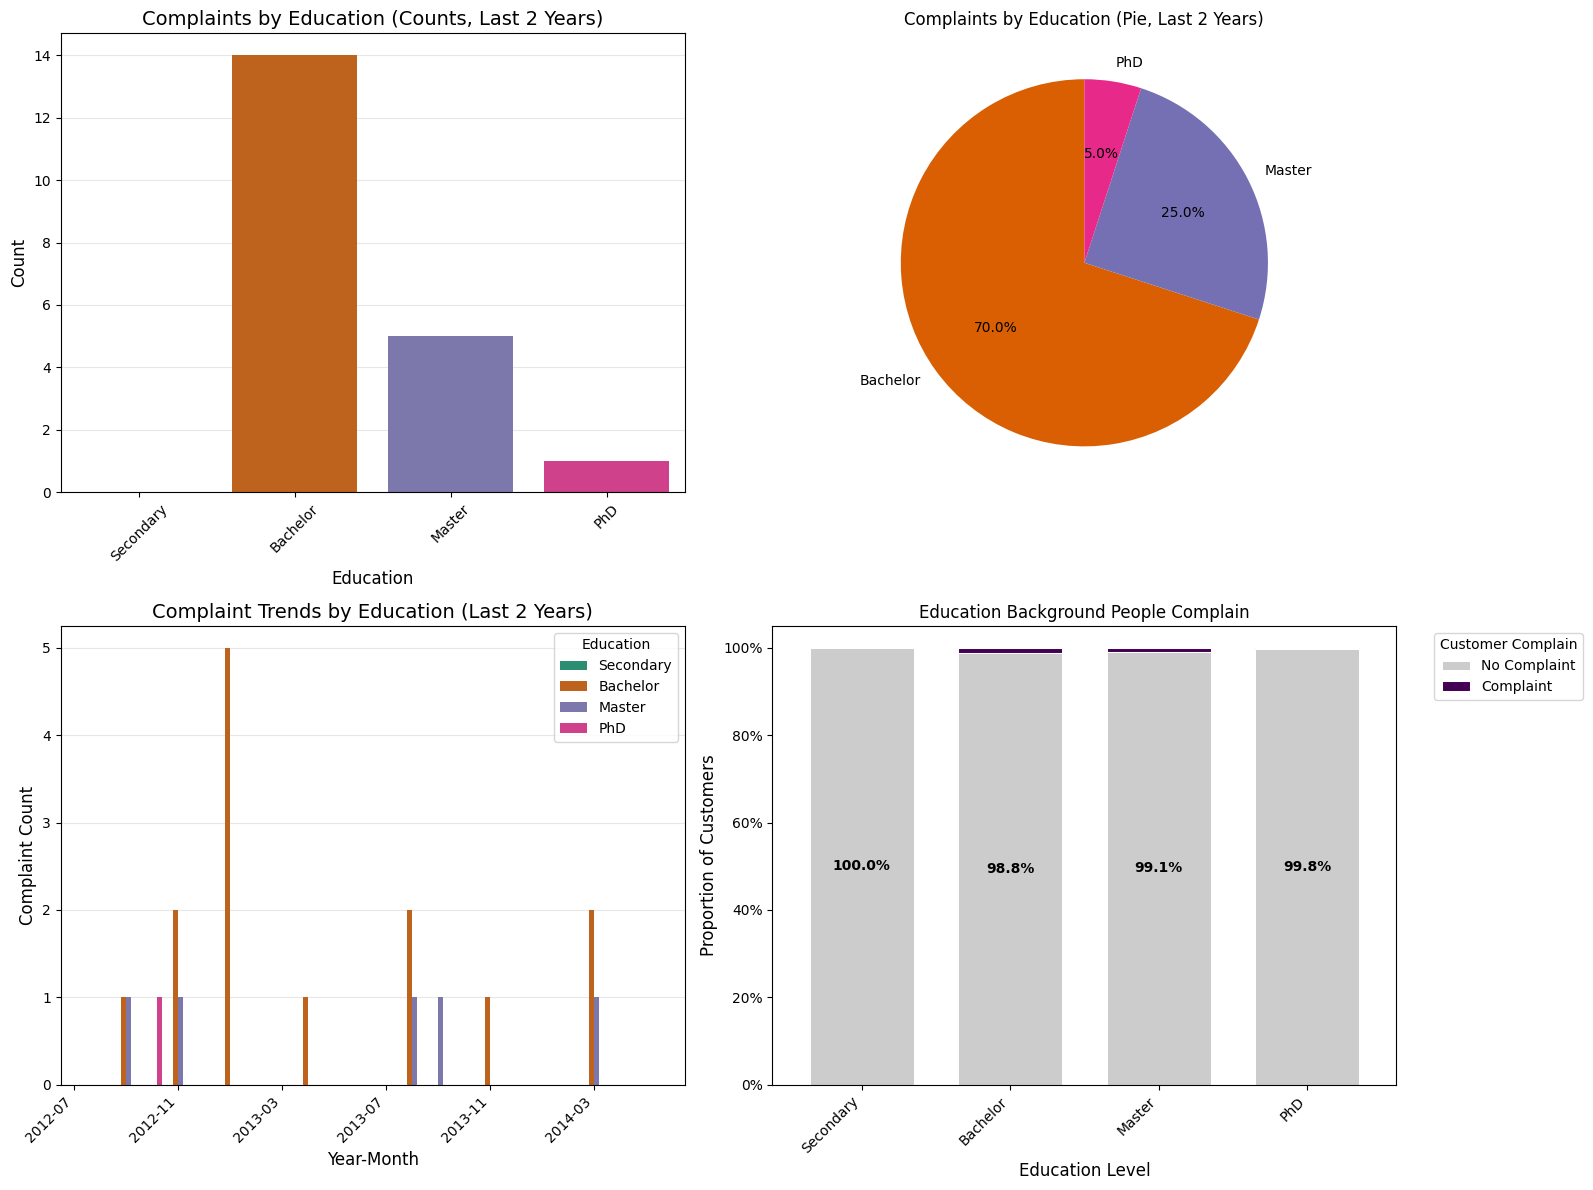

In [2]:
# --- Filter for last 2 years of data ---
latest_date = df["Dt_Customer"].max()
most_recent_date = df['Dt_Customer'].min()
cutoff_date = latest_date - pd.DateOffset(years=2)

complaints_recent = df[df["Dt_Customer"] >= cutoff_date].copy()
complaints_recent["YearMonth"] = complaints_recent["Dt_Customer"].dt.to_period("M")

# --- Map education numbers back to labels ---
edu_map = {
    1: 'Secondary',
    2: 'Bachelor',
    3: 'Master',
    4: 'PhD'
}
complaints_recent['Education'] = complaints_recent['Education_Encoded'].map(edu_map)

# --- Define order & palettes ---
edu_order = ['Secondary','Bachelor','Master','PhD']
#edu_palette = dict(zip(edu_order, sns.color_palette("Set2", len(edu_order))))
#edu_palette = dict(zip(edu_order, sns.color_palette("tab10", len(edu_order))))
edu_palette = dict(zip(edu_order, sns.color_palette("Dark2", len(edu_order))))
complain_palette = {0: "#cccccc", 1: "#440154"}  # grey = no complaint, purple = complaint

# --- Counts (complaints only) ---
edu_counts = complaints_recent.loc[complaints_recent["Complain"]==1, "Education"].value_counts()

# --- Complaint vs No Complaint proportions ---
complaint_share = (
    complaints_recent.groupby("Education")["Complain"]
    .value_counts(normalize=True)
    .rename("Proportion")
    .reset_index()
)

stacked_share = complaint_share.pivot(
    index="Education",
    columns="Complain",
    values="Proportion"
).fillna(0)

# --- Create subplot grid ---
reset_plot_settings()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Countplot (Complaints only)
ax1.set_axisbelow(True)
ax1.grid(True, axis='y', alpha=0.3, zorder=0)

sns.countplot(
    data=complaints_recent[complaints_recent["Complain"]==1],
    x="Education",
    order=edu_order,
    palette=edu_palette,
    ax=ax1
)
ax1.set_title("Complaints by Education (Counts, Last 2 Years)", fontsize=14)
ax1.set_xlabel("Education", fontsize=12)
ax1.set_ylabel("Count", fontsize=12)
ax1.tick_params(axis="x", rotation=45)

# 2. Pie chart (Complaints only)
ax2.pie(
    edu_counts,
    labels=edu_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=[edu_palette[edu] for edu in edu_counts.index]
)
ax2.set_title("Complaints by Education (Pie, Last 2 Years)")

# 3. Trend over time (Complaints only, chronological order)
ax3.set_axisbelow(True)
ax3.grid(True, axis='y', alpha=0.3, zorder=0)

order = sorted(complaints_recent["YearMonth"].unique())
sns.countplot(
    data=complaints_recent[complaints_recent["Complain"]==1],
    x="YearMonth",
    hue="Education",
    order=order,
    hue_order=edu_order,
    palette=edu_palette,
    ax=ax3
)
ax3.set_title("Complaint Trends by Education (Last 2 Years)", fontsize=14)
ax3.set_xlabel("Year-Month", fontsize=12)
ax3.set_ylabel("Complaint Count", fontsize=12)

n_ticks = 6  # Desired number of ticks
step = max(1, len(order) // n_ticks)
tick_positions = range(0, len(order), step)
tick_labels = [order[i] for i in tick_positions]

ax3.set_xticks(tick_positions)
ax3.set_xticklabels(tick_labels, rotation=45, ha='right')
ax3.legend(title="Education")

# 4. 100% Stacked Bar (Complaints vs No Complaints)
ax4.set_axisbelow(True)
ax4.grid(True, axis='y', alpha=0.3, zorder=0)

stacked_share.loc[edu_order].plot(
    kind="bar",
    stacked=True,
    ax=ax4,
    color=[complain_palette[c] for c in stacked_share.columns],
    width=0.7,
    edgecolor='white',  # Add white borders between segments
    linewidth=0.75
)

# Add percentage labels on each segment
for i, education in enumerate(edu_order):
    # Get the values for this education level
    no_complaint_pct = stacked_share.loc[education, 0] * 100  # Assuming 0 = No Complaint
    complaint_pct = stacked_share.loc[education, 1] * 100      # Assuming 1 = Complaint

    # Add label for "No Complaint" segment (bottom part)
    ax4.text(i, no_complaint_pct/200, f'{no_complaint_pct:.1f}%',
                ha='center', va='center', fontweight='bold', fontsize=10)

# Titles and labels
#ax4.set_title("Customer Complaint Rates by Education Level", fontsize=14)
ax4.set_title("Proportion of Complaints vs No Complaints by Education", fontsize=14)
ax4.set_ylabel("Proportion of Customers", fontsize=12)
ax4.set_xlabel("Education Level", fontsize=12)
ax4.set_xticklabels(edu_order, rotation=45, ha='right')

# Set y-axis to show percentages
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

ax4.legend(["No Complaint", "Complaint"],
           title="Customer Complain",
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           frameon=True,
           fancybox=True
          )

#ax4.spines['top'].set_visible(False)
#ax4.spines['right'].set_visible(False)
ax4.set_ylim(0, 1.05)  # Add some space at the top

plt.tight_layout()
save_project_figure(
    "Education_Background_People_Complain",
    "Education Background People Complain",
    config,
)
plt.show()

In [3]:
# Primary Insights:
# - Bachelor's Degree Holders Dominate Complaints
# - Bachelor's represent 70% of all complaints (pie chart) and have the highest absolute count (14 complaints)
# - Complaint Rates Are Consistently Low Across Education Levels
#   - All education groups show 98.8-100% "No Complaint" rates (stacked bar chart)
#   - Secondary education shows 100% satisfaction, while Bachelor's, Master's, and PhD all hover around 98.8-99.1%
#   - The differences between education levels are minimal (less than 2 percentage points)
# - Complaint Activity Is Sporadic
#   - The time trend shows complaints are infrequent and clustered
#   - Most time periods have zero complaints, with occasional spikes
#   - Bachelor's degree holders appear in most complaint periods

In [4]:

# Save results for next notebook
# save_intermediate_results(df_processed, 'processed_data.pkl', config)
# save_intermediate_results(analysis_results, 'analysis_results.pkl', config)
# print('✓ Results saved for next notebook')